In [2]:
import sys
sys.path.append("C:/Users/lhuang37/Desktop/oproject/Open-Catalyst-Dataset-OC22_dataset/")

from ocpmodels.common.relaxation.ase_utils import OCPCalculator
from ocpmodels.datasets import LmdbDataset
import os
from ase import Atoms
from ase.optimize import BFGS
import numpy as np
import pickle
import matplotlib.pyplot as plt
import lmdb
import pandas as pd
import ase
from pymatgen.entries.computed_entries import ComputedStructureEntry
from pymatgen.io.ase import AseAtomsAdaptor
from ase.visualize import view
# from ocdata.precompute_sample_structures import enumerate_surfaces_for_saving
from ocdata.precompute_sample_structures_self import enumerate_surfaces_for_saving as new_saving
import json
from ase.io import write
from ocdata.bulk_obj_oxide import Bulk
from ocdata.surfaces import Surface

In [3]:
from ase.geometry import get_layers
from tqdm import tqdm

In [3]:
plt.style.use('seaborn')
plt.rcParams.update({'font.size':18,
'xtick.labelsize':18,
'ytick.labelsize':18,
'font.size':18,
'axes.titlesize':24,
'axes.titleweight':'bold',
'axes.labelsize':18,
'axes.labelweight':'bold',
'legend.fontsize':16,
})

# 1. Extract bulk information

In [4]:
# load the bulk structures from json file
bulk_db = 'C:/Users/lhuang37/Desktop/oproject/Open-Catalyst-Dataset-OC22_dataset/ocdata/oc22_dataset/bulk_oxides_20220621.json'
bulk_db_raw_dict_list = json.load(open(bulk_db))
with open(bulk_db) as json_file:
    bulk_db_raw_dict_list = json.load(json_file)
    
bulk_db_raw_list = [ComputedStructureEntry.from_dict(d) for d in \
                          json.load(open(bulk_db))]
bulk_db_atoms_list = []
for bulk in bulk_db_raw_list:
    bulk_db_atoms_list.append(AseAtomsAdaptor.get_atoms(bulk.structure))

In [15]:
from script_v3 import slab_generator

In [ ]:
def get_bulk_info():
    pass

# 2. generate ase object and the related information

In [4]:
import torch
from torch_geometric.data import Data
from ase.constraints import FixAtoms
def convert_atoms_data(atoms:ase.Atoms,bulk_formula:str,bulk_energy:float,bulk_idx,r_energy=0,r_force=0,un_energy=0): 
    # input: 
    #    atoms object
    #    r_energy: add relaxed energy if add assign r_energy to a value
    #    r_force: add relaxed force matrix if assign r_force to a value
    #    un_force: add un-relaxed energy if assign un_energy to a value
    # output:
    #    Data object

    atomic_numbers=torch.Tensor(atoms.get_atomic_numbers())
    positions=torch.Tensor(atoms.get_positions())
    cell=torch.Tensor(np.array(atoms.get_cell())).view(1,3,3)
    natoms=positions.shape[0]
    tags=torch.Tensor(atoms.get_tags())
    fixed_idx=torch.zeros(natoms)    
    for constraint in atoms.constraints:
        if isinstance(constraint,FixAtoms):
            fixed_idx[constraint.index]=1
    data=Data(cell=cell,pos=positions,atomic_numbers=atomic_numbers,natoms=natoms,tags=tags)
    data.fixed=fixed_idx

    if r_energy != 0:
        data.y=r_energy
    if r_force != 0:
        data.force=r_force
    if un_energy !=0:
        data.unrelax_energy=un_energy

    data.slab_formula=atoms.get_chemical_formula()
    data.miller=atoms.info['miller_index']    
    data.bulk_formula=bulk_formula
    data.bulk_energy=bulk_energy
    data.entry_id=bulk_db_raw_list[bulk_idx].entry_id

    return data


In [36]:
demo_list=[10,100,1000,20,200]
data_list=[]
for bulk_idx in demo_list:
    bulk=bulk_db_atoms_list[bulk_idx]
    possible_invertible_surfaces=slab_generator(bulk,1,15,15)
    bulk_formula=bulk.symbols.get_chemical_formula()
    bulk_energy=bulk_db_raw_list[bulk_idx].energy
    for i in range(len(possible_invertible_surfaces)):
        data=convert_atoms_data(possible_invertible_surfaces[i],
                                bulk_formula=bulk_formula,
                                bulk_energy=bulk_energy,
                                bulk_idx=bulk_idx
                                )
        data_list.append(data)
    
len(data_list)
    

c:\Users\lhuang37\.conda\envs\ocp-models\lib\site-packages\pymatgen\core\surface.py:1327: UserWarning: Too many sites removed, please use a larger slab size.
  warnings.warn("Too many sites removed, please use a larger slab size.")


328

# 3. Slab energy calculation

In [55]:
%%capture out
calc = OCPCalculator(config_yml='../../configs/oc22/s2ef/gemnet-oc/gemnet_oc_oc20_oc22.yml', checkpoint="../gemnet_oc_base_oc20_oc22.pt",device='0')
for i in range(len(data_list)):
    data=data_list[i]
    testobj =Atoms(data.atomic_numbers,positions=data.pos,tags=data.tags,cell=data.cell.squeeze(),pbc=True)
    testobj.calc = calc
    unrelax_slab_energy = testobj.get_potential_energy()
    # Set up the calculator->predict relaxed total energy of slab
    opt = BFGS(testobj) 
    opt.run(fmax=0.05, steps=100)
    relax_slab_energy = testobj.get_potential_energy()
    data.y=relax_slab_energy
    data.unrelax_energy=unrelax_slab_energy
 

In [ ]:
import lmdb
db = lmdb.open(
    "datasetss/slabs5.lmdb",
    map_size=1099511627 * 2,
    subdir=False,
    meminit=False,
    map_async=True,
)
for i in range(len(data_list)): 
    data=data_list[i]  
    txn=db.begin(write=True)
    txn.put(f"{i}".encode('ascii'),pickle.dumps(data,protocol=0))
    txn.commit()
    db.sync()    
db.close()


# -1 draft

In [ ]:
def get_slab_lmdb(bulk_idx):
    bulk=bulk_db_atoms_list[bulk_idx]
    bulk_object = Bulk(bulk_db_raw_dict_list, bulk_index=bulk_idx)
    bulk_formula=bulk.symbols.get_chemical_formula()
    data=convert_atoms_data()



In [5]:
bulk_idx=4115
bulk=bulk_db_atoms_list[bulk_idx]


In [6]:
# possible_surfaces=new_saving(bulk,max_miller=1)

In [6]:
# output_folder='./output2/'
# os.makedirs(output_folder,exist_ok=True)
# sur_enes={}
# bulk_ase = bulk_db_atoms_list[bulk_idx]
# data=

In [7]:

def surface_area_func(atom_obj:Atoms)->float:
    #input: atoms object
    #output: surface area
    atom_cell=np.array(atom_obj.get_cell())
    return np.linalg.norm(np.cross(atom_cell[0],atom_cell[1]))

In [24]:
%%capture out
# i=0
bulk_object = Bulk(bulk_db_raw_dict_list, bulk_index=bulk_idx)
bulk_formula=bulk_ase.symbols.get_chemical_formula()
for surface_idx in tqdm(range(len(possible_invertible_surfaces))):
    miller = possible_invertible_surfaces[surface_idx].info['miller_index']
    surface_ase=possible_invertible_surfaces[surface_idx]
    surface_formula = surface_ase.get_chemical_formula()
    testobj = surface_ase  
    surface_area = surface_area_func(testobj)
    write(output_folder + 'bulk_' + bulk_formula +'_surface_' +str(surface_idx) +'_miller' +str(miller) +'.png', testobj, rotation='89x,75y,176z')
    # energy_list.append(surface_energy)
    # view(testobj)
    # break
    surface_areas.append(surface_area)
    # i+=1
    # if i>100:
    #     break

In [59]:
seeit=LmdbDataset({"src": "datasetss/slabs5.lmdb"})
seeit[0]

Data(pos=[200, 3], cell=[1, 3, 3], atomic_numbers=[200], natoms=200, tags=[200], fixed=[200], slab_formula='Fe12Mn52O136', miller=[3], bulk_formula='Fe2Mn10O24', bulk_energy=-289.1648123696, entry_id='mp-755276', y=-1332.6395263671875, unrelax_energy=-1328.212890625)

In [14]:
from ocpmodels.preprocessing import AtomsToGraphs
a2g = AtomsToGraphs(
    max_neigh=50,
    radius=6,
    r_energy=True,    # False for test data
    r_forces=True,
    r_distances=False,
    r_fixed=True,
)


In [15]:
%%capture out
sur_enes={}
calc = OCPCalculator(config_yml='../../configs/oc22/s2ef/gemnet-oc/gemnet_oc_oc20_oc22.yml', checkpoint="../gemnet_oc_base_oc20_oc22.pt",device='0')
for surface_idx in range(len(possible_invertible_surfaces)):
    miller = possible_invertible_surfaces[surface_idx].info['miller_index']
    surface_ase=possible_invertible_surfaces[surface_idx]
    surface_formula = surface_ase.get_chemical_formula()
    bulk_object = Bulk(bulk_db_raw_dict_list, bulk_index=bulk_idx)  
    bulk_formula=bulk_ase.symbols.get_chemical_formula()  
    testobj = surface_ase
    testobj.calc = calc
    unrelax_slab_energy = testobj.get_potential_energy()
    # Set up the calculator->predict relaxed total energy of slab
    opt = BFGS(testobj) 
    opt.run(fmax=0.05, steps=100)
    relax_slab_energy = testobj.get_potential_energy()
    slab_bulk_ratio_n = len(testobj.get_atomic_numbers())/len(bulk_ase.get_atomic_numbers())
    surface_area = surface_area_func(testobj)
    bulk_energy = bulk_db_raw_list[bulk_idx].energy
    # surface_energy = (unrelax_slab_energy - slab_bulk_ratio_n * bulk_energy)/(2*surface_area) + (relax_slab_energy -unrelax_slab_energy)/surface_area
    surface_energy = (relax_slab_energy - slab_bulk_ratio_n * bulk_energy)/(2*surface_area) 
    sur_enes[surface_idx]={}
    sur_enes[surface_idx]['sur_formula']=surface_formula   
    sur_enes[surface_idx]['miller']=miller
    sur_enes[surface_idx]['left']=(relax_slab_energy-0.4 - slab_bulk_ratio_n * bulk_energy)/(2*surface_area) 
    sur_enes[surface_idx]['mid']=(relax_slab_energy - slab_bulk_ratio_n * bulk_energy)/(2*surface_area) 
    sur_enes[surface_idx]['right']=(relax_slab_energy+0.4 - slab_bulk_ratio_n * bulk_energy)/(2*surface_area) 
    fosave=a2g.convert(testobj)
    fosave.slab_formula=surface_formula 
    fosave.unrelax_energy=unrelax_slab_energy
    fosave.bulk_energy=bulk_energy 
    fosave.miller=miller
    fosave.bulk_formula=bulk_formula
    # testobj.info['surface_formula']=surface_formula   
    # testobj.info['total_energy']=relax_slab_energy
    # testobj.info['bulk_energy']=bulk_energy
    txn=db.begin(write=True)
    txn.put(f"{surface_idx}".encode('ascii'),pickle.dumps(fosave,protocol=0))
    txn.commit()
    db.sync()
    #write(output_folder + 'bulk_' + bulk_formula +'_surface_' +surface_formula +'_miller' +str(miller) +'_energy_'+str(round(surface_energy, 4))+'.png', testobj, rotation='10z,-80x')
db.close()

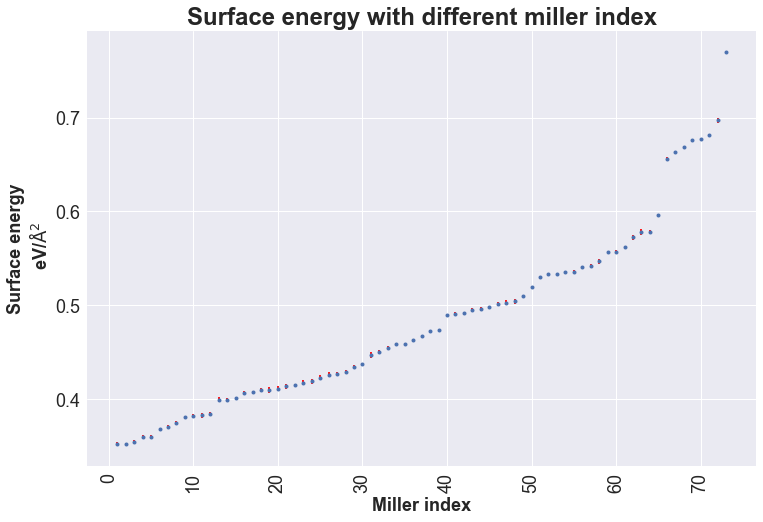

In [21]:
df=pd.DataFrame.from_dict(sur_enes).T
df.sort_values(by=['mid'],inplace=True)
df['new_order']=range(1,len(df)+1)
plt.figure(figsize=(12,8))
plt.errorbar(x=df['new_order'], y=df['mid'], yerr=[df['mid'] - df['left'], df['right'] - df['mid']], fmt='o', ecolor='red',markersize=4)
plt.title('Surface energy with different miller index')
plt.xlabel('Miller index')
plt.ylabel('Surface energy\n eV/$\mathrm{\AA}^{2}$')
plt.xticks(rotation='vertical')
plt.show()

In [22]:
df

,sur_formula,miller,left,mid,right,new_order
11,O64Ti36,"(1, 1, 1)",0.350163,0.352213,0.354264,1
65,O128Ti64,"(0, 1, 0)",0.351033,0.352316,0.3536,2
9,O68Ti36,"(1, 1, 1)",0.352633,0.354683,0.356734,3
31,O68Ti36,"(1, 1, -1)",0.357232,0.359446,0.361659,4
26,O72Ti36,"(1, 1, -1)",0.357243,0.359456,0.36167,5
...,...,...,...,...,...,...
50,O132Ti60,"(1, 0, -1)",0.674243,0.675699,0.677154,69
33,O192Ti90,"(1, 0, 1)",0.675722,0.676858,0.677994,70
43,O180Ti84,"(1, 0, 0)",0.679821,0.681159,0.682496,71
66,O60Ti24,"(0, 0, 1)",0.694191,0.697067,0.699943,72


In [23]:
df.to_csv("TiO2_results",index=False)

In [24]:
df111=pd.read_csv("TiO2_results")

In [25]:
df111

,sur_formula,miller,left,mid,right,new_order
0,O64Ti36,"(1, 1, 1)",0.350163,0.352213,0.354264,1
1,O128Ti64,"(0, 1, 0)",0.351033,0.352316,0.353600,2
2,O68Ti36,"(1, 1, 1)",0.352633,0.354683,0.356734,3
3,O68Ti36,"(1, 1, -1)",0.357232,0.359446,0.361659,4
4,O72Ti36,"(1, 1, -1)",0.357243,0.359456,0.361670,5
...,...,...,...,...,...,...
68,O132Ti60,"(1, 0, -1)",0.674243,0.675699,0.677154,69
69,O192Ti90,"(1, 0, 1)",0.675722,0.676858,0.677994,70
70,O180Ti84,"(1, 0, 0)",0.679821,0.681159,0.682496,71
71,O60Ti24,"(0, 0, 1)",0.694191,0.697067,0.699943,72


In [99]:
df_new=df[df['miller']==(1, 1, 1)]

In [100]:
df_new

,sur_formula,miller,left,mid,right,new_order
11,O64Ti36,"(1, 1, 1)",0.350163,0.352213,0.354264,1
9,O68Ti36,"(1, 1, 1)",0.352631,0.354682,0.356733,3
5,O72Ti36,"(1, 1, 1)",0.365721,0.367772,0.369823,6
6,O72Ti36,"(1, 1, 1)",0.368649,0.3707,0.37275,7
7,O80Ti40,"(1, 1, 1)",0.372543,0.374594,0.376645,8
10,O72Ti40,"(1, 1, 1)",0.378504,0.380555,0.382605,9
4,O80Ti40,"(1, 1, 1)",0.382068,0.384119,0.386169,12
8,O76Ti40,"(1, 1, 1)",0.397511,0.399562,0.401612,14
2,O68Ti32,"(1, 1, 1)",0.448264,0.450315,0.452366,32
3,O76Ti36,"(1, 1, 1)",0.460582,0.462633,0.464683,36


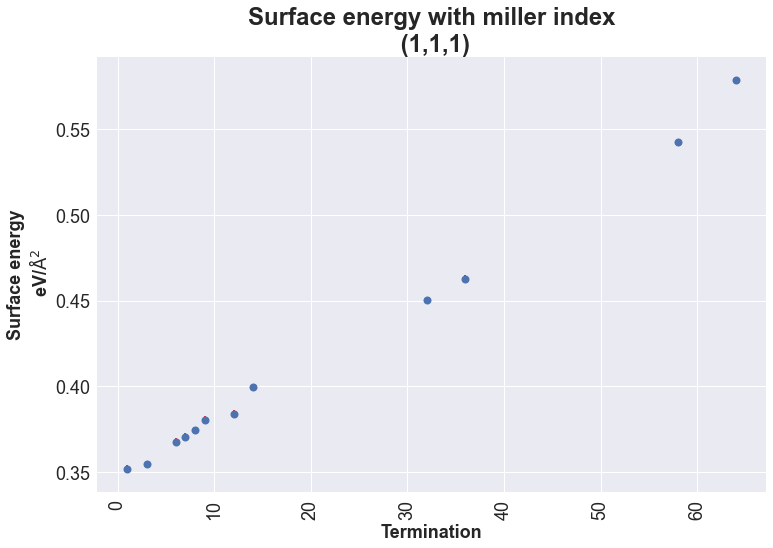

In [105]:
plt.figure(figsize=(12,8))
plt.errorbar(x=df_new['new_order'], y=df_new['mid'], yerr=[df_new['mid'] - df_new['left'], df_new['right'] - df_new['mid']], fmt='o', ecolor='red',markersize=8)
plt.title('Surface energy with miller index\n (1,1,1)')
plt.xlabel('Termination')
plt.ylabel('Surface energy\n eV/$\mathrm{\AA}^{2}$')
plt.xticks(rotation='vertical')
plt.show()

In [26]:
from PIL import Image
import imageio
import os


In [27]:

# Path to directory containing images
path = output_folder

# List all files in directory with .jpg extension
image_files = [f for f in os.listdir(path) if f.endswith('.png')]

# Create an array of images
images = []
for file_name in image_files:
    file_path = os.path.join(path, file_name)
    image = Image.open(file_path)
    images.append(image)

# Save the images as a GIF
imageio.mimsave('output.gif', images)

In [106]:
import lmdb

In [ ]:
surface_formula = surface_ase.get_chemical_formula()
['surface_formula']=surface_formula 

In [109]:
testobj=possible_invertible_surfaces[0]
surface_formula = testobj.get_chemical_formula()
testobj.info['surface_formula']=surface_formula

testobj.info

{'miller_index': (1, 1, 1), 'surface_formula': 'O72Ti32'}

In [ ]:
for idx in range(len(possible_invertible_surfaces)):
    testobj=possible_invertible_surfaces[idx]
    surface_formula = testobj.get_chemical_formula()
    testobj.info['surface_formula']   
    txn=db.begin(write=True)
    txn.put(f"{idx}".encode('ascii'),pickle.dumps(testobj,protocol=0))
    txn.commit()
    db.sync()
db.close()